In [1]:
%pylab inline
import os,sys,re
import pickle
from builtins import sum as bsum
from importlib import reload
from collections import defaultdict, namedtuple
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])

In [3]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; reload(units); UNITS = units.UNITS;

In [4]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


# Specify the analysis window

In [5]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[3]
fit_k         = False
fit_b         = True

SAVEPLOTS = True # Whether to actually make the plots
fig_dir_full        = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = fit_k, fit_b=fit_b, create = True); print(f"{fig_dir_full=}")
fig_dir_wnd_shp_len = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_wnd_shp_len=}")
fig_dir_wnd_shp     = fpft.get_fig_dir(window_shape = window_shape, window_length = None,          fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_wnd_shp=}")
fig_dir_top         = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_top=}")
fig_dir_fitkb       = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = fit_k, fit_b=fit_b, create = True); print(f"{fig_dir_fitkb=}")

fig_dir_full='figs/kaiser16/1s/fit_k=False/fit_b=True'
fig_dir_wnd_shp_len='figs/kaiser16/1s'
fig_dir_wnd_shp='figs/kaiser16'
fig_dir_top='figs'
fig_dir_fitkb='figs/fit_k=False/fit_b=True'


# Specify the datasets to use

In [6]:
to_use = {
    "16Ts":{"sim_name":"n16Tslow"},
    "bw":  {"sim_name":"boulder16"},
    # "s=w": {"sim_name":"surr_all_equal", "surrogate_k": 0},
    #"s=p": {"sim_name":"surr_all_equal", "surrogate_k": 4},
    # "shw": {"sim_name":"surr_high",      "surrogate_k": 0},          
    "shp": {"sim_name":"surr_high",      "surrogate_k": 4},
    # "s=w_q0":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":0},
    # "s=w_q1":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":pi/3},
}

In [7]:
#to_use = {"bw":  {"sim_name":"boulder16"}}
for pw, k in zip("pw",[4]):
    for r in range(10):
        to_use[f"s={pw}_{r}"] = {"sim_name":"surr_all_equal", "surrogate_k":k, "random_seed":r}


# Load the data

In [8]:
safe_load = lambda d: d[0] if d is not None else d
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];
loaded = {k:safe_load(proc.load_data(init_filter = v,
                                       compute_filter = {
                                           "window_shape":window_shape,
                                           "window_length":window_length,
                                           "fit_k":fit_k,
                                           "fit_b":fit_b,
                                       },
                                     fit_corrs = ["search.1"],
                                     ))
          for k,v in to_use.items()}

data =  {k:FisherPlumes(d) for k,d in loaded.items() if d is not None}

for k, l in loaded.items():
    if l is None:
        print(f"WARNING: No data for {k=}")

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];
    

                    proc 2023/11/10 15:33:58     INFO: Loading init_filter={'sim_name': 'n16Tslow'} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/n16Ts.1/1b4a6d7a7ad24dc6.p, last modified 2023-11-08 15:38:45.


                    proc 2023/11/10 15:34:02     INFO: proc/n16Ts.1/fit_corrs/search.1/1b4a6d7a7ad24dc6.p does not exist.


                    proc 2023/11/10 15:34:02     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:02     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/bw.1/b64c5ea843419d08.p, last modified 2023-11-08 15:35:12.


                    proc 2023/11/10 15:34:03     INFO: proc/bw.1/fit_corrs/search.1/b64c5ea843419d08.p does not exist.


                    proc 2023/11/10 15:34:03     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:03     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/shp.1/203cc026cad3a72c.p, last modified 2023-11-08 15:31:56.


                    proc 2023/11/10 15:34:03     INFO: proc/shp.1/fit_corrs/search.1/203cc026cad3a72c.p does not exist.


                    proc 2023/11/10 15:34:03     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:03     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 0} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.00/1ca94f3dfadf1153.p, last modified 2023-11-08 15:31:56.


                    proc 2023/11/10 15:34:03     INFO: proc/s=p.00/fit_corrs/search.1/1ca94f3dfadf1153.p does not exist.


                    proc 2023/11/10 15:34:03     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:04     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 1} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.01/7e3569f147c43d70.p, last modified 2023-11-08 15:32:01.


                    proc 2023/11/10 15:34:04     INFO: proc/s=p.01/fit_corrs/search.1/7e3569f147c43d70.p does not exist.


                    proc 2023/11/10 15:34:04     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:04     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 2} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.02/9cb57ebb00bbf998.p, last modified 2023-11-08 15:31:46.


                    proc 2023/11/10 15:34:04     INFO: proc/s=p.02/fit_corrs/search.1/9cb57ebb00bbf998.p does not exist.


                    proc 2023/11/10 15:34:04     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:04     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 3} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.03/89a432c4f17b63ee.p, last modified 2023-11-08 15:31:26.


                    proc 2023/11/10 15:34:05     INFO: proc/s=p.03/fit_corrs/search.1/89a432c4f17b63ee.p does not exist.


                    proc 2023/11/10 15:34:05     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:05     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 4} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.04/4f3ea7043b7e36c6.p, last modified 2023-11-08 15:31:32.


                    proc 2023/11/10 15:34:05     INFO: proc/s=p.04/fit_corrs/search.1/4f3ea7043b7e36c6.p does not exist.


                    proc 2023/11/10 15:34:05     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:05     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 5} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.05/e0eabfd3725e548c.p, last modified 2023-11-08 15:31:46.


                    proc 2023/11/10 15:34:06     INFO: proc/s=p.05/fit_corrs/search.1/e0eabfd3725e548c.p does not exist.


                    proc 2023/11/10 15:34:06     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:06     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 6} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.06/8409ef43ba52182a.p, last modified 2023-11-08 15:31:55.


                    proc 2023/11/10 15:34:06     INFO: proc/s=p.06/fit_corrs/search.1/8409ef43ba52182a.p does not exist.


                    proc 2023/11/10 15:34:06     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:06     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 7} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.07/622bbca300cb1e95.p, last modified 2023-11-08 15:32:08.


                    proc 2023/11/10 15:34:06     INFO: proc/s=p.07/fit_corrs/search.1/622bbca300cb1e95.p does not exist.


                    proc 2023/11/10 15:34:07     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:07     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 8} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.08/2a8170d60b88c03b.p, last modified 2023-11-08 15:32:08.


                    proc 2023/11/10 15:34:07     INFO: proc/s=p.08/fit_corrs/search.1/2a8170d60b88c03b.p does not exist.


                    proc 2023/11/10 15:34:07     INFO: Returning 1 results.


                    proc 2023/11/10 15:34:07     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 9} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.09/71bfc68c9c703717.p, last modified 2023-11-08 15:32:57.


                    proc 2023/11/10 15:34:07     INFO: proc/s=p.09/fit_corrs/search.1/71bfc68c9c703717.p does not exist.


                    proc 2023/11/10 15:34:07     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data':

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 4, 'surrogate_k': 4}, 'seed': 4, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 5, 'surrogate_k': 4}, 'seed': 5, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 6, 'surrogate_k': 4}, 'seed': 6, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 7, 'surrogate_k': 4}, 'seed': 7, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 8, 'surrogate_k': 4}, 'seed': 8, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 9, 'surrogate_k': 4}, 'seed': 9, 

In [9]:
reload(fp)
for k, d in data.items():
    if k in ["bw", "16Ts"]:
        data[k] = fp.FisherPlumes(d)
        data[k].compute_fit_metrics()

           fisher_plumes 2023/11/10 15:34:11     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7fa571ec8be0> is a FisherPlumes object named n16Tslow.


           fisher_plumes 2023/11/10 15:34:11     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:34:11    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field tvvals.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field sim0.


           fisher_plumes 2023/11/10 15:34:12    DEBUG: Copied field sims.


           fisher_plumes 2023/11/10 15:34:12     INFO: Copied 40 data fields from FisherPlumes object.


           fisher_plumes 2023/11/10 15:34:12     INFO: Computing R^2-values.


           fisher_plumes 2023/11/10 15:34:12     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/11/10 15:34:27     INFO: Computing TV-values.


           fisher_plumes 2023/11/10 15:34:27     INFO: (Skipping TV-value computation for bootstraps.)


           fisher_plumes 2023/11/10 15:34:43     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7fa571ec83a0> is a FisherPlumes object named boulder16.


           fisher_plumes 2023/11/10 15:34:43     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field tvvals.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field sim0.


           fisher_plumes 2023/11/10 15:34:43    DEBUG: Copied field sims.


           fisher_plumes 2023/11/10 15:34:43     INFO: Copied 40 data fields from FisherPlumes object.


           fisher_plumes 2023/11/10 15:34:43     INFO: Computing R^2-values.


           fisher_plumes 2023/11/10 15:34:43     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/11/10 15:34:50     INFO: Computing TV-values.


           fisher_plumes 2023/11/10 15:34:50     INFO: (Skipping TV-value computation for bootstraps.)


# Figure showing an example plume and correlations

In [10]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k,v in to_use.items() if v["sim_name"].startswith("surr")]
surrQ = lambda x: x in su_ds
surr_trialsQ = lambda x: any([x.startswith(s) for s in ["s=p_", "s=w_"]])
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],
                                       "cr":[490000,510000],
                                       "w1":[107300, 114700], "w2":[218300,225700], "w3":[329300,336700],"w4":[440300,447700],
                                       "12T":[498000,502000], "12Ts":[498000,502000],
                                       "16T":[496000,504000], "16Ts":[496000,504000],
},       
                                      su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
snapshot_time = defaultdict(lambda: 40000*UNITS.ms, {"12T":10001*UNITS.ms, "12Ts":40010*UNITS.ms,"16T":10001*UNITS.ms, "16Ts":40010*UNITS.ms})

Surrogate datasets = ['shp', 's=p_0', 's=p_1', 's=p_2', 's=p_3', 's=p_4', 's=p_5', 's=p_6', 's=p_7', 's=p_8', 's=p_9'].


[440000, 448000, 456000, 464000, 472000, 480000, 488000, 496000, 504000, 512000, 520000, 528000, 536000, 544000, 552000, 560000]


      fisher_plumes_figs 2023/11/10 15:34:58     INFO: Clipped snapshots to limsx=array([ 42, 488]), limsy=array([ 33, 405]).


Wrote figs/kaiser16/1s/plumes_demo_16Ts.pdf.


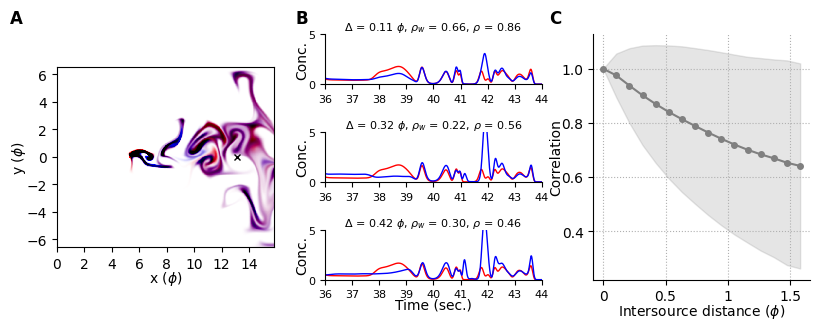

INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


Wrote figs/kaiser16/1s/plumes_demo_bw.pdf.


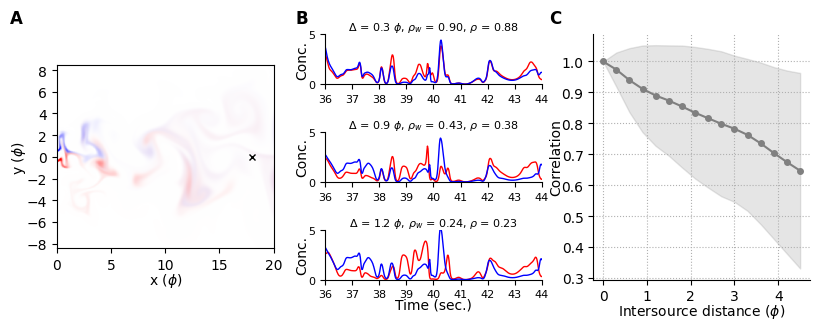

In [11]:
reload(fpf)
reload(fpft)

for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, snapshot_time[k], which_srcs[k],
                                                    t_center = (snapshot_time[k].to(UNITS.ms).magnitude//1000)*1000 * UNITS.ms,
                                                    y_lim = (0,5.01) if not surrQ(k) else (-3.01,3.01), y_ticks = [-3,0,3] if surrQ(k) else None,
                                                        data_dir = os.path.join(boulder.data_root, "saved-snapshots") if k == "bw" else None,
                                                    t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if surrQ(k) or k  in ["bw"]: ax_corr.set_xticks(arange(5))
    if surrQ(k): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir_wnd_shp_len}/plumes_demo_{k}.pdf"
    #ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Set the probe index we'll use

In [12]:
iprb = 0

# Figure showing the distribution of correlations

16Ts
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_16Ts.pdf.


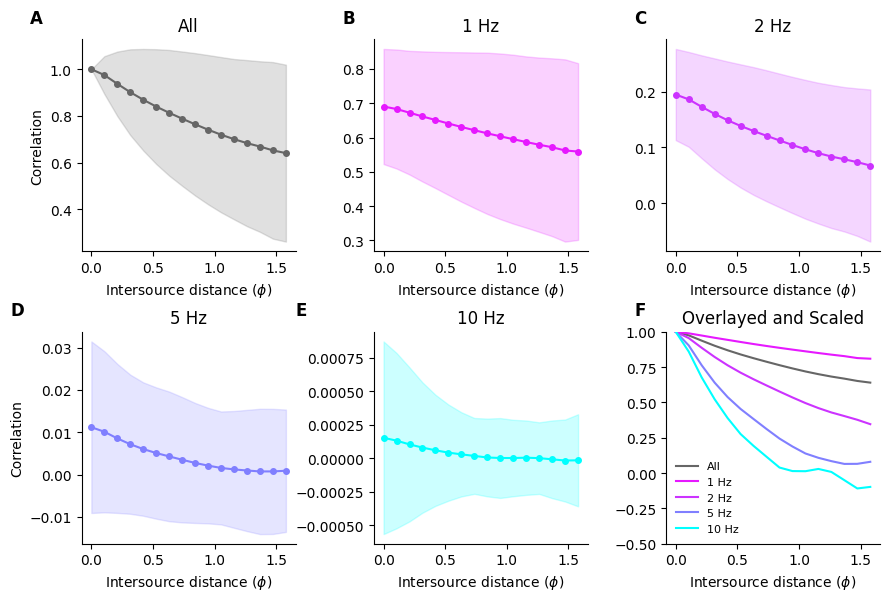

bw
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_bw.pdf.


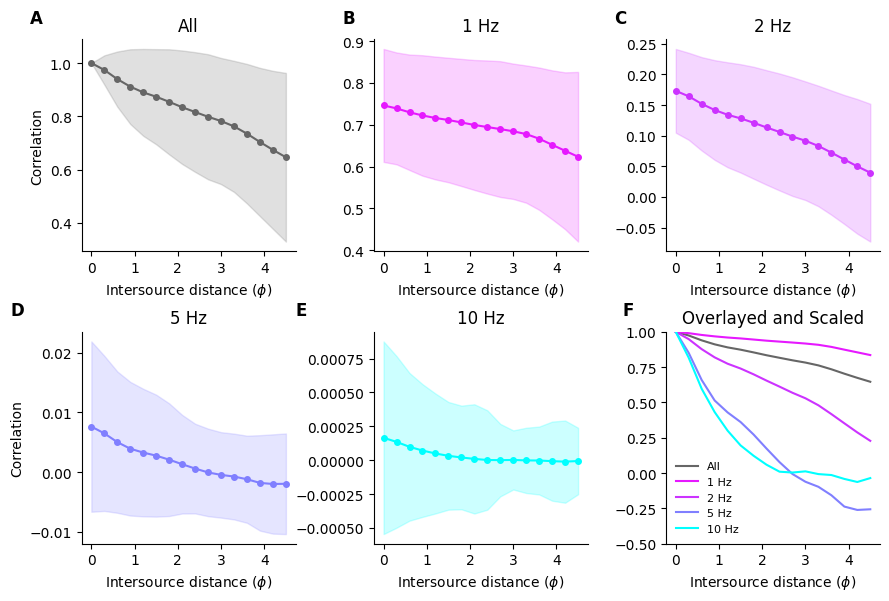

shp
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_shp.pdf.


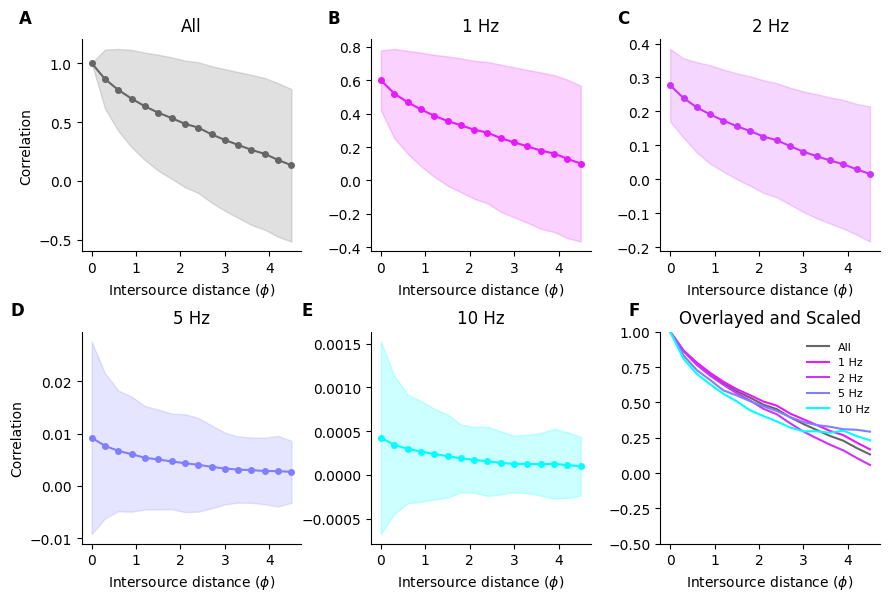

s=p_0
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_s=p_0.pdf.


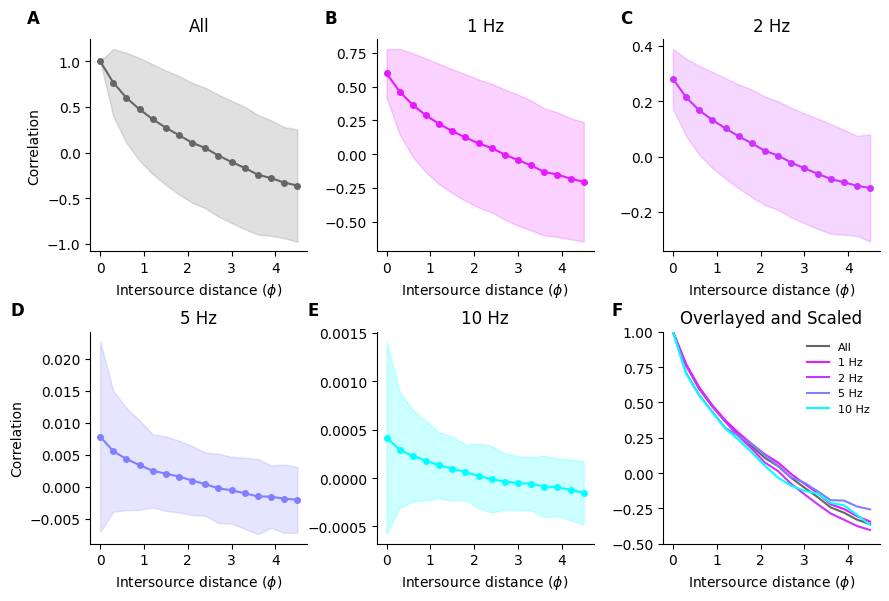

In [13]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    if k.startswith("s=p"):
        if not k == "s=p_0":
            continue
    which_freqs = [1,2,5,10] * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir_wnd_shp_len}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# Phase relationships

{'a': (0.45, 0.5625), 'b': (0.55, 0.5625), 'c': (0.45, 0.4375), 'd': (0.55, 0.4375)}


Wrote figs/kaiser16/1s/a_vs_bcd_bw_5Hz_idist=1.pdf.


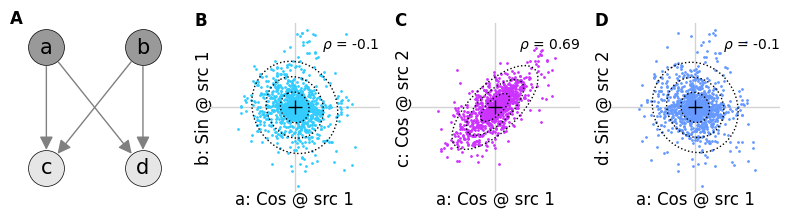

In [14]:
reload(fpf)
which_freq   = 5 * UNITS.Hz
which_idists = defaultdict(lambda: 1, {"bw":1})

for name, F in data.items():
    if name != "bw": continue
    figure(figsize=(8,3))
    ifreq = F.freqs2inds([which_freq])[0]
    idist = which_idists[name]
    axes = [subplot(1,4,i+1) for i in range(4)]
    plt.sca(axes[0])
    fpf.plot_gm(sc=4.5, scale=[0.1,0.125],dxy=[0,0])    
    axes[0].axis("square")
    axes[0].set_ylim([0.41,0.59])
    ax_ = fpf.plot_a_vs_bcd(F, ifreq, idist, cols = [cm.cool(0.2), cm.cool(0.8), cm.cool(0.4)], al=[-0.5,0.5], ax = axes[1:])
    tight_layout()
    fpft.label_axes(axes, "ABCD", fontsize=12, fontweight="bold", dy=-0.01, align_y=[0,1,2,3])            
    file_name = f"{fig_dir_wnd_shp_len}/a_vs_bcd_{name}_{which_freq.magnitude}Hz_{idist=}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()


# The Multivariate Gaussian Fits

16Ts
bw
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_bw_5Hz_a_c__a_d.pdf.


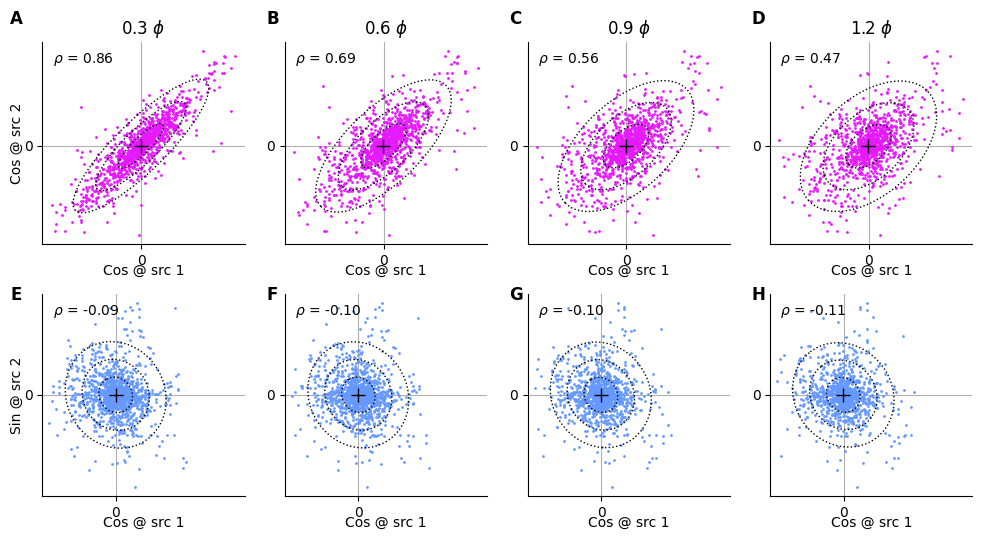

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_bw_10Hz_a_c__a_d.pdf.


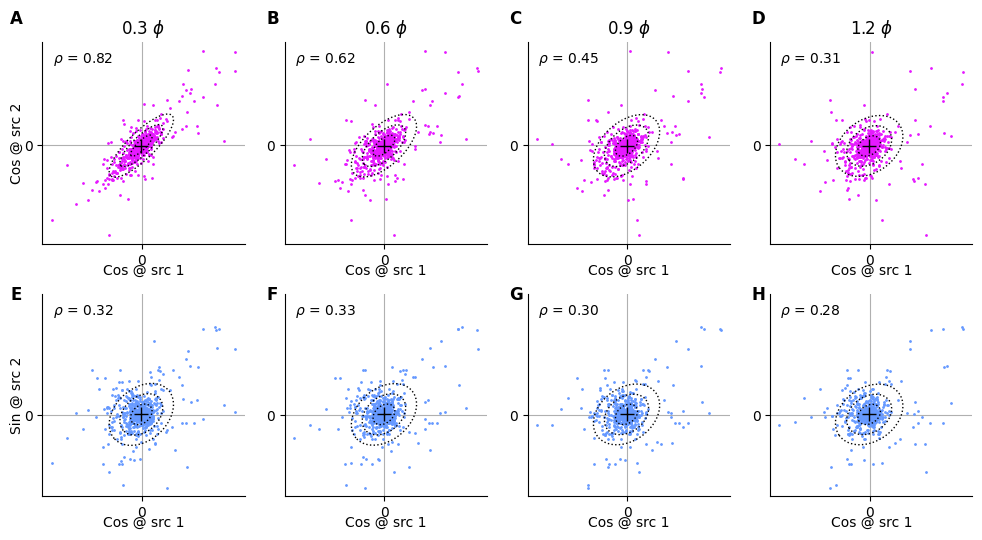

s=p_0
s=p_1
s=p_2
s=p_3
s=p_4
s=p_5
s=p_6
s=p_7
s=p_8
s=p_9
shp


In [15]:
reload(fpf)
freqs_to_plot = [5 * UNITS.Hz, 10 * UNITS.Hz]
which_freqs = dict_update_from_field({"bw":freqs_to_plot,   },   su_ds + ["16Ts"], "bw"); 
which_idists= dict_update_from_field({"bw":[0,1,2,3],         },   su_ds + ["16Ts"], "bw"); 
dcol_scales = dict_update_from_field({"bw":120000,          },   su_ds + ["16Ts"], "bw");
configs = ["a_c", "a_d"]
cols    = [cm.cool(r) for r in [0.9, 0.4]]
for name, F in sorted(data.items()):
    print(name)
    if surr_trialsQ(name): continue
    if name!="bw": continue
    for which_freq in which_freqs[name]:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        
        figure(figsize=(12, 3 * len(configs)))
        axes = []
        for i, config in enumerate(configs):
            idists = which_idists[name]
            ax = [subplot(len(configs), len(idists), i*len(idists) + j+1) for j in range(len(idists))]
            ax_ = fpf.plot_coef1_vs_coef2(F,
                                          ifreq,
                                          config=config,
                                          iprb=iprb,
                                          i_pos_dists_to_plot = which_idists[name],
                                          col = cols[i],
                                          axes = ax,
                                          do_corr = True,
            )
            if i:
                [axi.set_title("") for axi in ax_]
                        
            axes.extend(ax)
        fpft.label_axes(axes, "ABCDEFGH", fontsize=12, fontweight="bold", dy=-0.01)            
        file_name = f"{fig_dir_wnd_shp_len}/coef_vs_coef_{name}_{which_freq.magnitude}Hz_{'__'.join(configs)}.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Supplementary Information

In [16]:
reload(fpf)
reload(fpft)
freq      = dict_update_from_field({"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz},        su_ds + ["16Ts", "16T"], "bw"); 
idists    = dict_update_from_field({"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}, su_ds + ["16Ts", "16T"], "bw"); 
t_lim     = dict_update_from_field({"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec,  "16T":[9.5,10.5]*UNITS.sec},  su_ds + ["16Ts"], "bw")
dt        = dict_update_from_field({"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec},         su_ds + ["16Ts"], "bw", ["16T"], "cr");
# for k, F in sorted(data.items()):
#     if surrQ(k): continue
#     if surr_trialsQ(k): continue
#     figure(figsize=(12,6))
#     coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
#                                                          which_probe = iprb, n_per_row = 2,
#                                                          y_lim=[0,5] if k[:2]!="su" else [-3,3],
#                                                          t_lim = t_lim[k],
#                                                          dt = dt[k])
#     for ax in coef_ax:
#         ax.set_xlabel("")
#         ax.set_ylabel("")
#     [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
#     tight_layout(pad=0)
#     all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
#     n_ax   = len(all_ax)
#     fpft.label_axes(all_ax,
#                     [ch+nu for ch in "ABCDEFGH" for nu in "12"],
#                     align_x = [list(range(i,n_ax,4)) for i in range(4)],
#                     align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
#                     fontsize=12, fontweight="bold", dy=-0.01)
#     file_name = f"{fig_dir_wnd_shp_len}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.png" # Use png as these figures have lots of points
#     SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
#     sys.stdout.flush(); plt.show()

# Plot scattergrams

16Ts
Mapped 2 Hz to index 2.


Wrote figs/kaiser16/1s/scattergram_16Ts_2Hz.pdf.


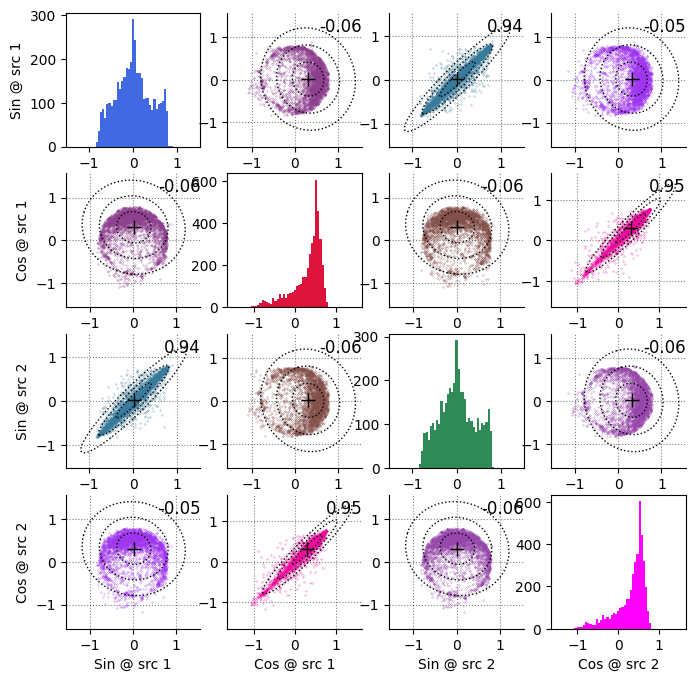

Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/scattergram_16Ts_5Hz.pdf.


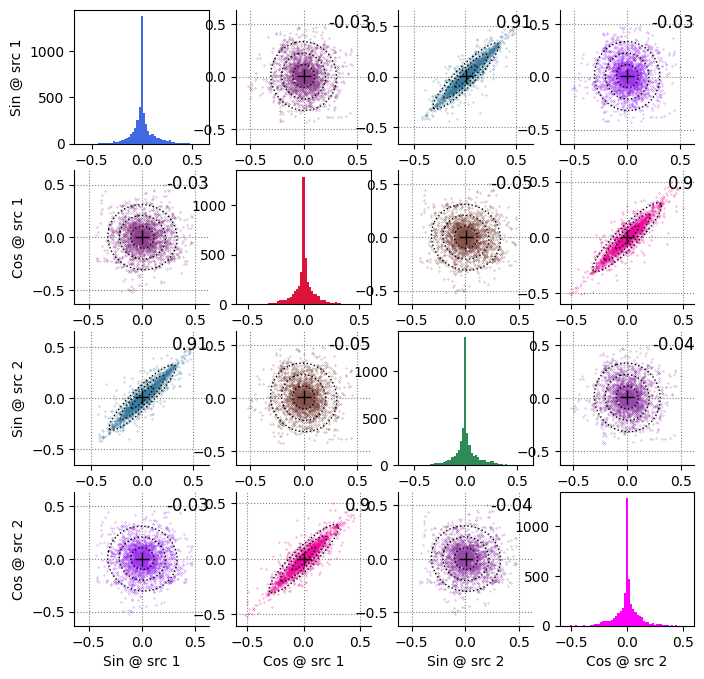

Mapped 8 Hz to index 8.


Wrote figs/kaiser16/1s/scattergram_16Ts_8Hz.pdf.


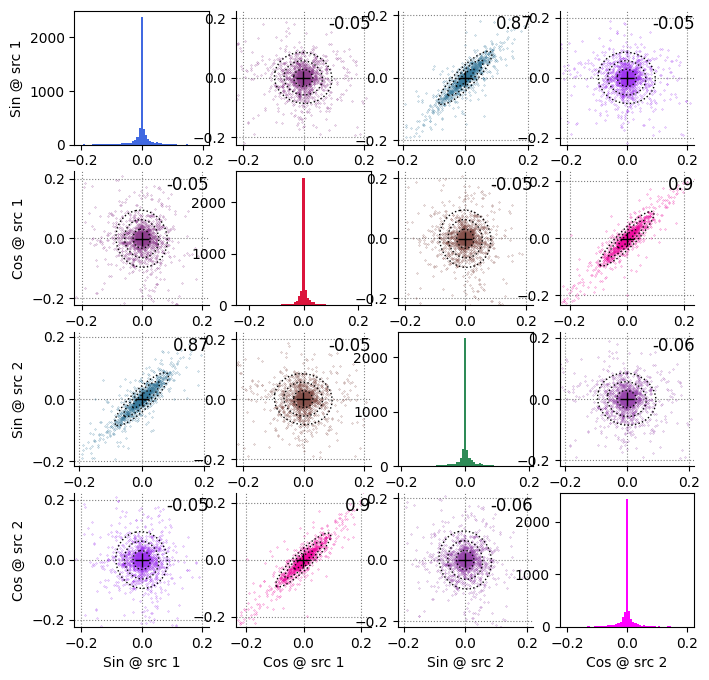

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/scattergram_16Ts_10Hz.pdf.


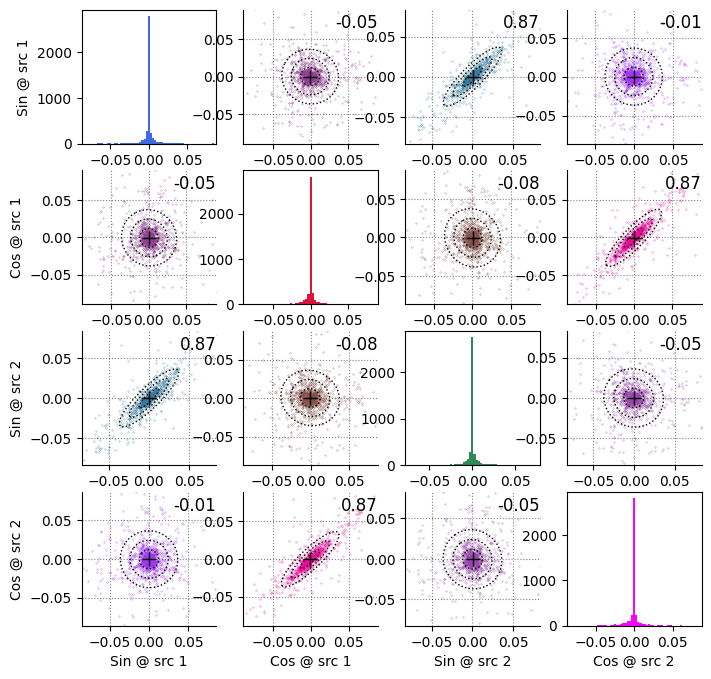

bw
Mapped 2 Hz to index 2.


Wrote figs/kaiser16/1s/scattergram_bw_2Hz.pdf.


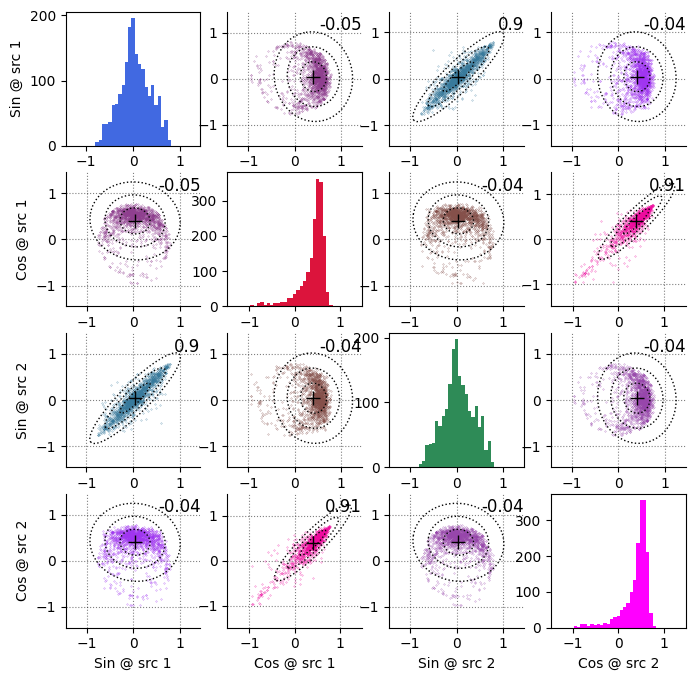

Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/scattergram_bw_5Hz.pdf.


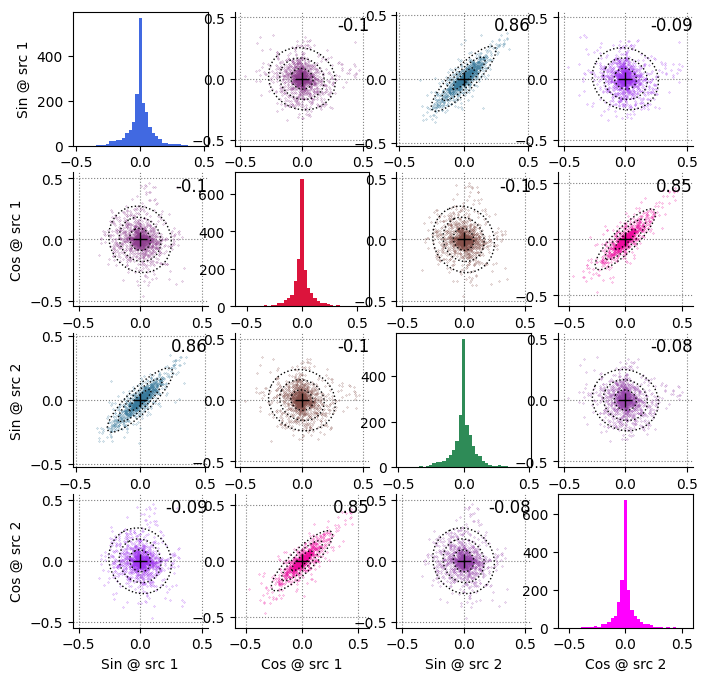

Mapped 8 Hz to index 8.


Wrote figs/kaiser16/1s/scattergram_bw_8Hz.pdf.


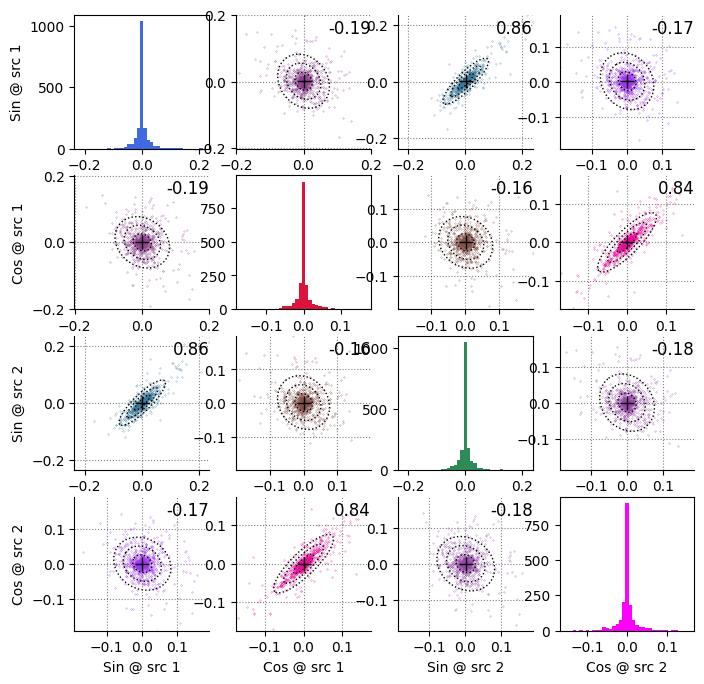

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/scattergram_bw_10Hz.pdf.


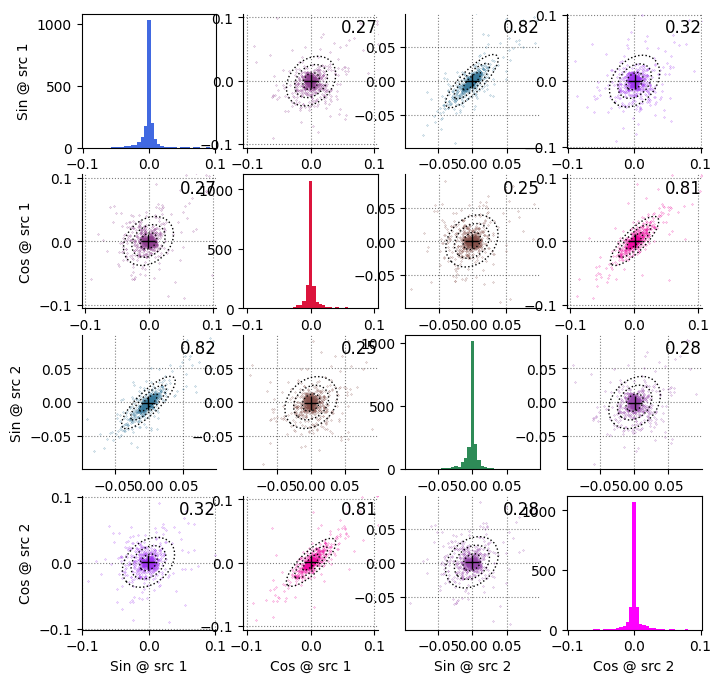

s=p_0
s=p_1
s=p_2
s=p_3
s=p_4
s=p_5
s=p_6
s=p_7
s=p_8
s=p_9
shp
Mapped 2 Hz to index 2.


Wrote figs/kaiser16/1s/scattergram_shp_2Hz.pdf.


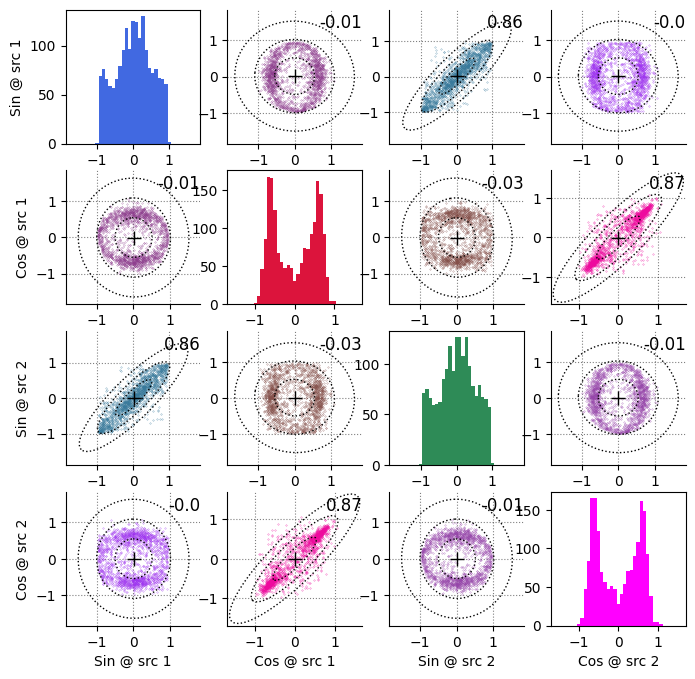

Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/scattergram_shp_5Hz.pdf.


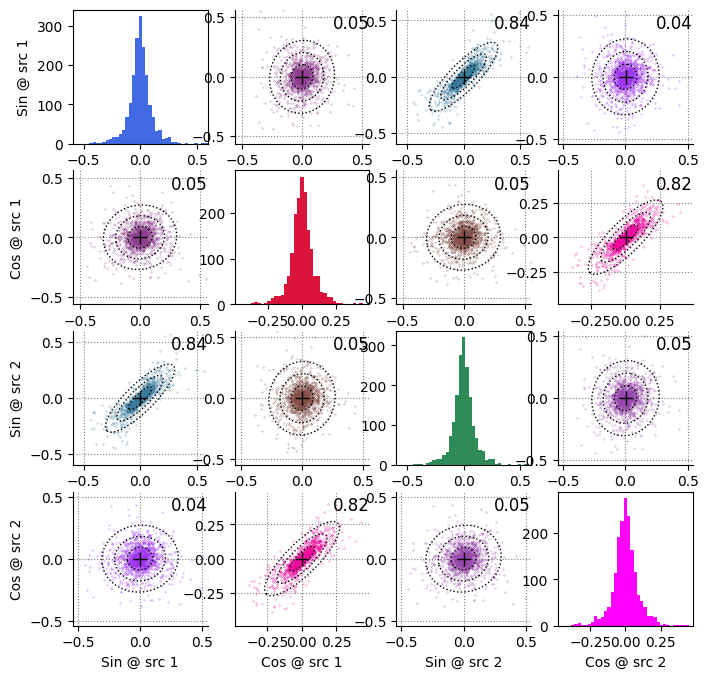

Mapped 8 Hz to index 8.


Wrote figs/kaiser16/1s/scattergram_shp_8Hz.pdf.


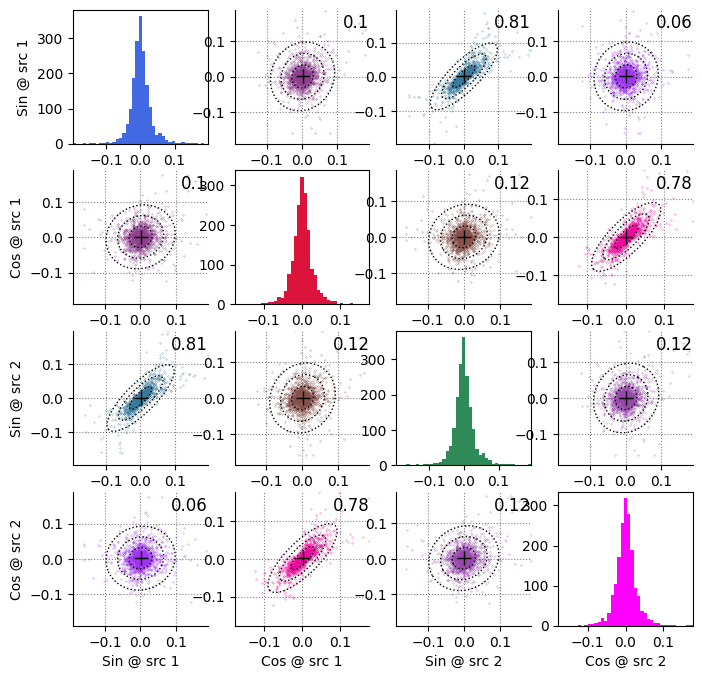

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/scattergram_shp_10Hz.pdf.


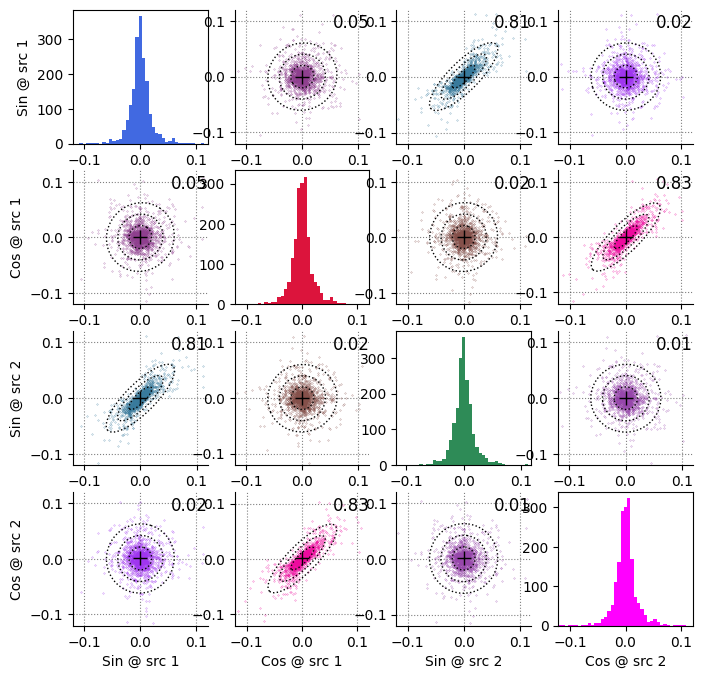

In [17]:
reload(fpft)
reload(fpf)
freqs_to_plot = [2 * UNITS.Hz, 5 * UNITS.Hz, 8 * UNITS.Hz, 10 * UNITS.Hz]
#freqs_to_plot = [1 * UNITS.Hz]#, 5 * UNITS.Hz, 8 * UNITS.Hz, 10 * UNITS.Hz]
which_freqs = dict_update_from_field({"bw":freqs_to_plot,   "cr":freqs_to_plot},   su_ds + ["16Ts"], "bw"); 
for name, F in sorted(data.items()):
    print(name)
    if surr_trialsQ(name): continue
    for which_freq in which_freqs[name]:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        ax = fpf.plot_scattergram(F,
                                  ifreq,
                                  iprb,
                                  figsize=(8,8),
                                  dist_col_scale = dcol_scales[name],
                                  markersize = 0.2,
                                  cols = ["royalblue","crimson", "seagreen", "magenta"],
                                  coef_names = {0:"Sin", 1:"Cos"},
                                  lim_scale = 2.,
                                  print_fun = np.corrcoef,
                                  )
        file_name = f"{fig_dir_wnd_shp_len}/scattergram_{name}_{which_freq.magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Relative contribution of in-phase-component

Wrote figs/kaiser16/1s/phase_heatmap_16Ts.pdf.


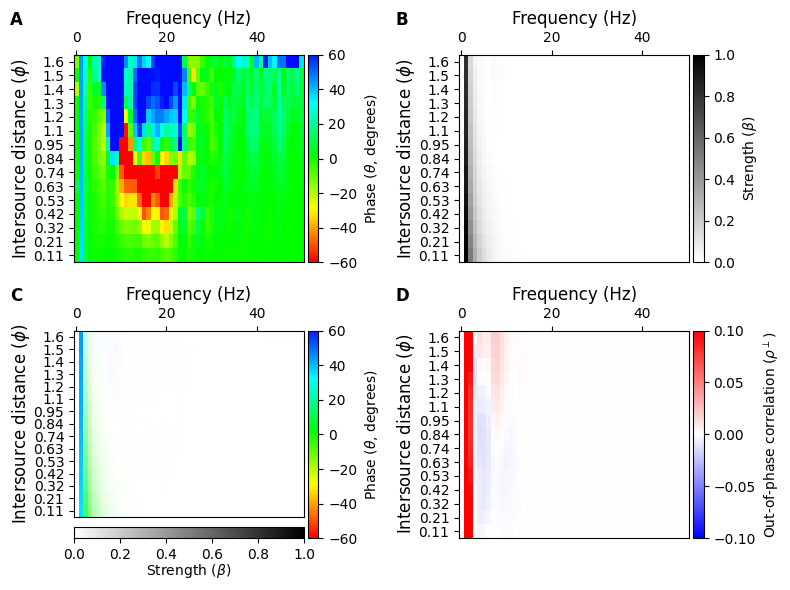

Wrote figs/kaiser16/1s/phase_heatmap_bw.pdf.


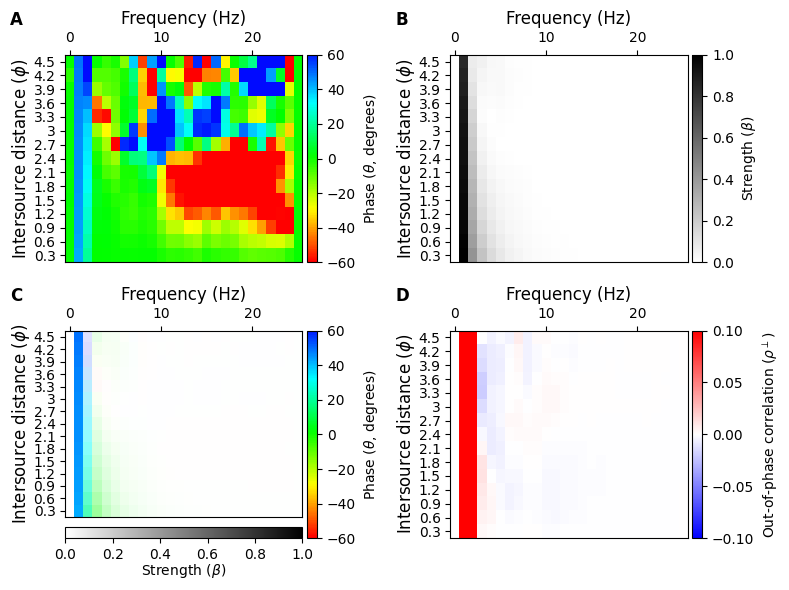

Wrote figs/kaiser16/1s/phase_heatmap_shp.pdf.


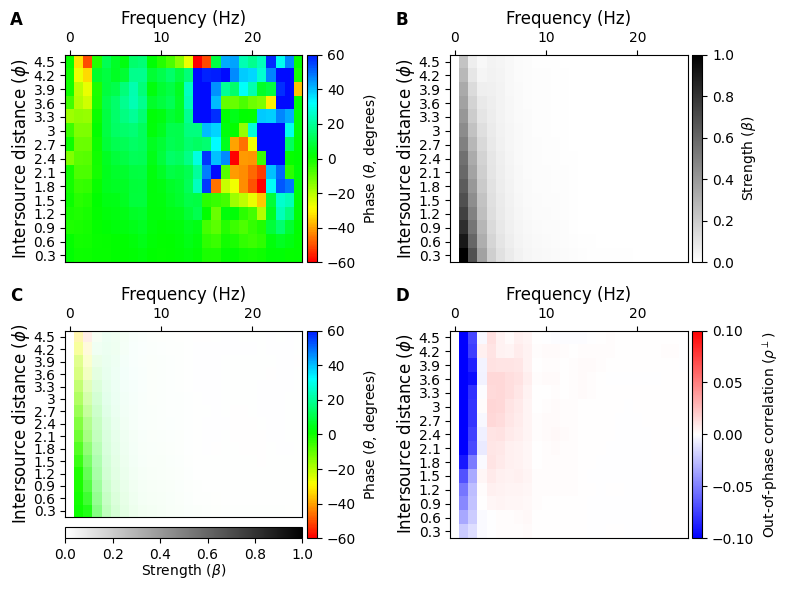

In [18]:
reload(fpf)
for name, F in sorted(data.items()):
    if surr_trialsQ(name): continue
    ax = fpf.plot_phase_heatmap(F, max_phi = pi/3, plot_which="all", max_corr=0.1,figsize=(8,6))
    plt.tight_layout()
    fpft.label_axes(ax, "ABCD", 
                    align_y = [[0,1],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.025)
    file_name = f"{fig_dir_wnd_shp_len}/phase_heatmap_{name}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Asymmetric Laplacian Fits

In [19]:
reload(fpft)
reload(fpf)
idist     = dict_update_from_field({"bw":[0,1,2],          "cr":[1,13,15]},         su_ds + ["16Ts"], "bw", ["16T"],"cr")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmin      = dict_update_from_field({"bw":[0,0],          "cr":[0,0]},           su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmax      = dict_update_from_field({"bw":[1,1],           "cr":[1,1]},            su_ds + ["16Ts"], "bw", ["16T"],"cr")
for name, F in sorted(data.items()):
    if surrQ(name): continue
    if surr_trialsQ(name): continue
    if name != "bw": continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f, xl in zip([1,5,10] * UNITS.hertz, [[-0.25, 1.0], [-0.02, 0.05], [-0.02, 0.05]]):
        if f != 5 * UNITS.hertz: continue
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                                                        ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                                                        which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(9,4),
                                                        fit_color="gray",
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        expansion = 1.0,
                                                        xl = xl,
                                                        fit_corrs = "search.1",
                                                        leg_loc = None,
                                                        leg_loc2 = "lower right",
                                                        cdf_mode = "even")
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]],
                        align_x = [[0,3],[1,4],[2,5],[6,7]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_wnd_shp_len}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

bw


ValueError: F does not have a fit_corrs field.

# Plot the figure showing ρ(s)

      fisher_plumes_figs 2023/11/10 15:35:52     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 3, 7, 10], log_scale=True.


Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/rho_vs_s_fits_16Ts.pdf.


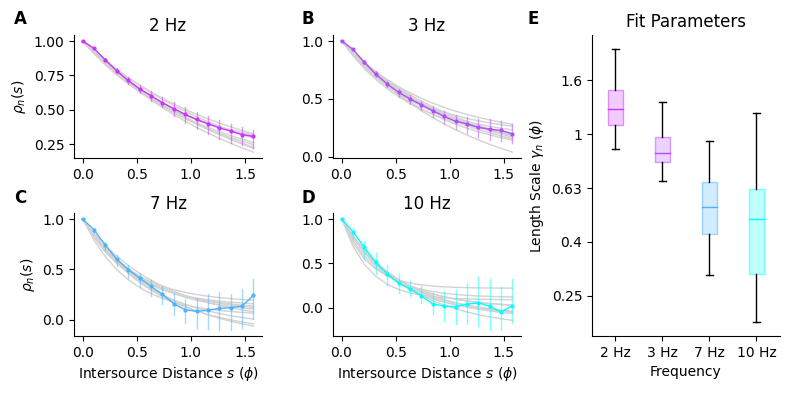

      fisher_plumes_figs 2023/11/10 15:35:53     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 3, 7, 10], log_scale=True.


Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/rho_vs_s_fits_bw.pdf.


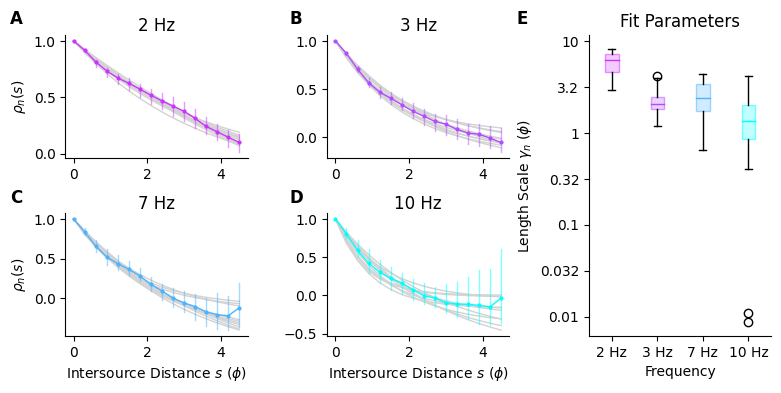

In [20]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[2,3,7,10] * UNITS.hertz for fld in ["bw", "cr", "su", "16T", "16Ts"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds + ["16Ts"], "bw", ["16T"], "cr")
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds + ["16Ts"], "bw", ["16T"], "cr")
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds + ["16Ts"], "bw", ["16T"], "cr")
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds + ["16Ts"], "bw", ["16T"], "cr")

#print(f"{wnd_key=:}")
#data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          max_bs = 10,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir_full}/rho_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the Fisher Information

      fisher_plumes_figs 2023/11/10 15:35:54     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/11/10 15:35:54     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


16Ts
bw


Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/fisher_info_bw.pdf.


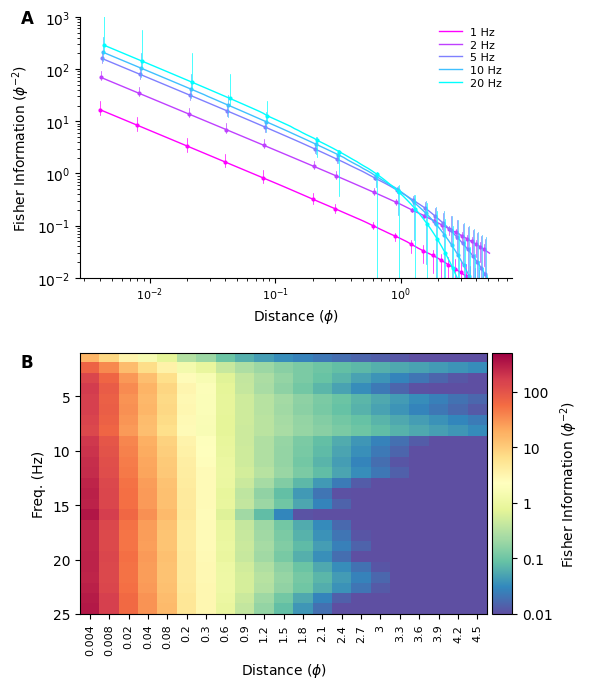

s=p_0
s=p_1
s=p_2
s=p_3
s=p_4
s=p_5
s=p_6
s=p_7
s=p_8
s=p_9
shp


In [21]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds + ["16Ts"], "bw", ["16T"], "cr")
plot_param_fits = False
for k, F in sorted(data.items()):
    print(k)
    if k != "bw": continue
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir_full}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

In [22]:
order = ["bw", "s=p_0", "shp", "bw"]
which_wnd = [(1 * UNITS.s, 'hann')] * 3 + [(1 * UNITS.s, 'boxcar')]
data_wnd = [FisherPlumes(proc.load_data(init_filter=to_use[o],
                                          compute_filter = {"window_length":wnd[0],
                                                            "window_shape":wnd[1],
                                                            "fit_k":fit_k, "fit_b":True})[0], load_sims=False) for o,wnd in zip(order,which_wnd)]

                    proc 2023/11/10 15:35:56     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': False, 'fit_b': True} from proc/bw.1/a870f77347a4942f.p, last modified 2023-08-30 21:20:15.


                    proc 2023/11/10 15:35:57     INFO: Returning 1 results.


           fisher_plumes 2023/11/10 15:35:57     INFO: Initializing from dictionary.


           fisher_plumes 2023/11/10 15:35:57     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Skipping field sim0 because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Skipping field sims because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:57     INFO: Copied 37 data fields from supplied dictionary.


                    proc 2023/11/10 15:35:57     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 0} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': False, 'fit_b': True} from proc/s=p.00/3fb65457ca4e1f95.p, last modified 2023-09-29 12:33:17.


                    proc 2023/11/10 15:35:57     INFO: Returning 1 results.


           fisher_plumes 2023/11/10 15:35:57     INFO: Initializing from dictionary.


           fisher_plumes 2023/11/10 15:35:57     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Skipping field sim0 because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:57    DEBUG: Skipping field sims because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:57     INFO: Copied 37 data fields from supplied dictionary.


                    proc 2023/11/10 15:35:57     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': False, 'fit_b': True} from proc/shp.1/9aa0c12903638012.p, last modified 2023-08-30 21:17:04.


                    proc 2023/11/10 15:35:58     INFO: Returning 1 results.


           fisher_plumes 2023/11/10 15:35:58     INFO: Initializing from dictionary.


           fisher_plumes 2023/11/10 15:35:58     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Skipping field sim0 because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:58    DEBUG: Skipping field sims because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:58     INFO: Copied 37 data fields from supplied dictionary.


                    proc 2023/11/10 15:35:58     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'boxcar', 'fit_k': False, 'fit_b': True} from proc/bw.1/68a5c7b1f718189b.p, last modified 2023-08-30 21:19:38.


                    proc 2023/11/10 15:35:59     INFO: Returning 1 results.


           fisher_plumes 2023/11/10 15:35:59     INFO: Initializing from dictionary.


           fisher_plumes 2023/11/10 15:35:59     INFO: Attempting to copy data fields.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field name.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field pitch_string.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field pitch.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field pairs_um.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field n_bootstraps.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field random_seed.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field yvals_um.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field pairs_mode.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field wnd.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field freq_max.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field fs.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field dimensions.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field freqs.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field stft.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field ss.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field cc.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field tt.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field vars_for_freqs.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field rho.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field la.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field mu.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field phi.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field beta.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field pvals.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field r2vals.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field fit_params.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field dd_fit.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field coef_γ_vs_freq.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field I_dists.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field I.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field Ilow.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field Ihigh.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field I_pcs.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field reg_freq_range.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field reg_type.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field reg_params.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Copied field reg_coefs.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Skipping field sim0 because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:59    DEBUG: Skipping field sims because it is in dont_copy.


           fisher_plumes 2023/11/10 15:35:59     INFO: Copied 37 data fields from supplied dictionary.


Wrote figs/fit_k=False/fit_b=True/fisher_info_heatmaps.pdf.


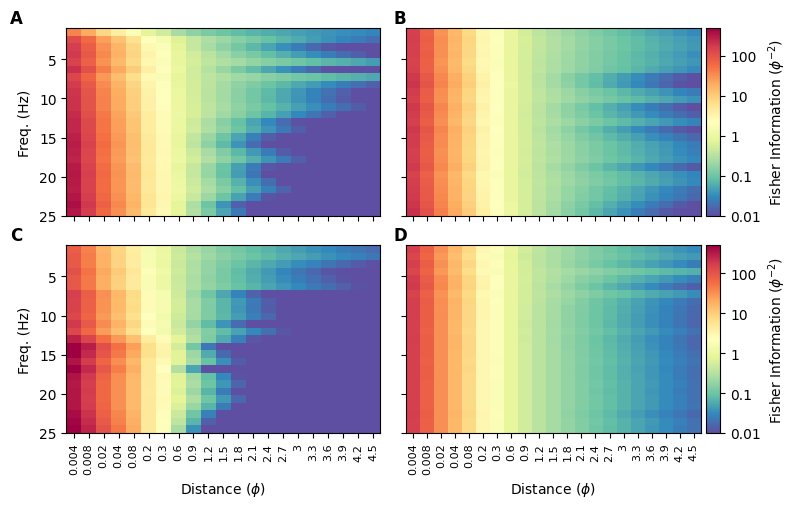

In [23]:
# Compare our heatmap (A) to surrogate data where
# (B) All frequencies are equally informative
# (C) High freqs arr equally informative
# (D) Our data but with a boxcar window
figure(figsize=(8,5))
gs = GridSpec(2,2)
axes, cbs = [], []
for (o, gsi, datai) in zip(order, gs, data_wnd):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(datai, 0, ax = axes[-1], freq_max = 25 * UNITS.Hz,
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitkb}/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

# Main figure showing effect of windowing

In [24]:
# row_vals = ["s=p_0", "shp", "bw"]
# col_vals = [(10 * UNITS.s, 'boxcar'), (1 * UNITS.s, 'hann'), (5 * UNITS.s, 'hann')]
# data_grid= {(r,c):FisherPlumes(proc.load_data(init_filter=to_use[r], compute_filter = {"window_length":c[0], "window_shape":c[1], "fit_k":fit_k, "fit_b":True})[0], load_sims=False) for r in row_vals for c in col_vals}

In [25]:
# reload(fpf)
# fig = figure(figsize=(8,5))
# heatmap_range = defaultdict(lambda: [-2, log10(500)], {"bw":[-2,log10(500)], "su_high2_pink":[-2,log10(500)]})
# gs       = GridSpec(len(row_vals), len(col_vals))
# ax       = []
# for i, ds in enumerate(row_vals):
#     for j, ck in enumerate(col_vals):
#         ax.append(subplot(gs[i,j]))
#         p = data_grid[ds,ck]
#         _, cb = fpf.plot_fisher_information_heatmap(
#             p, 0, ax = ax[-1], heatmap_range = heatmap_range[ds],
#             do_colorbar = gs[i,j].is_last_col(),
#         )
#         # Write text above each column
        
#         i == 0 and fig.text({0:0.2,1:0.5,2:0.78}[j],1.0,f"{ck[0]} {utils.remove_non_alphanum(ck[1])}",va="center", ha="center", fontsize=12)
#         if gs[i,j].is_last_col() and i!=1: cb.ax.set_ylabel("")
#         if not gs[i,j].is_first_col(): ax[-1].set_ylabel("")
#         if not gs[i,j].is_last_row():  [ax[-1].set_xlabel(""),ax[-1].set_xticklabels([])]
# tight_layout(w_pad = 1.5, h_pad=1.5)
# fpft.label_axes(ax, "ABCDEFGHI",
#                 align_y = [[0,1,2],[3,4,5],[6,7,8]],
#                 align_x = [[0,3,6],[1,4,7],[2,5,8]],
#                 fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
# file_name = f"{fig_dir_fitkb}/effect_of_windowing.pdf"
# SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
# sys.stdout.flush(); plt.show()
        


# Length constants vs frequency

Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/length_vs_freq_bw.pdf.


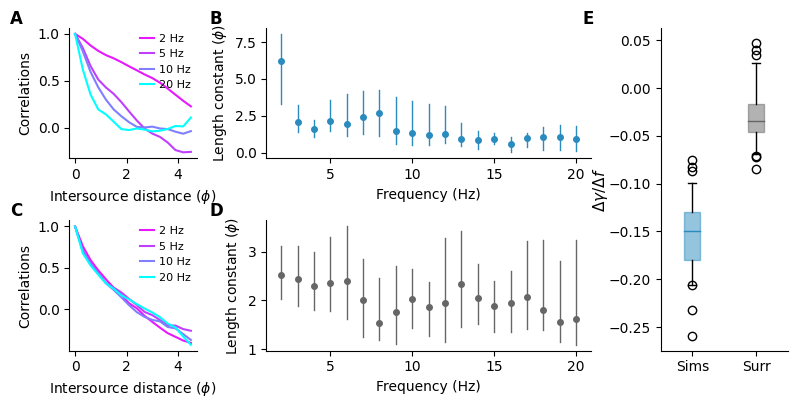

Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/length_vs_freq_16Ts.pdf.


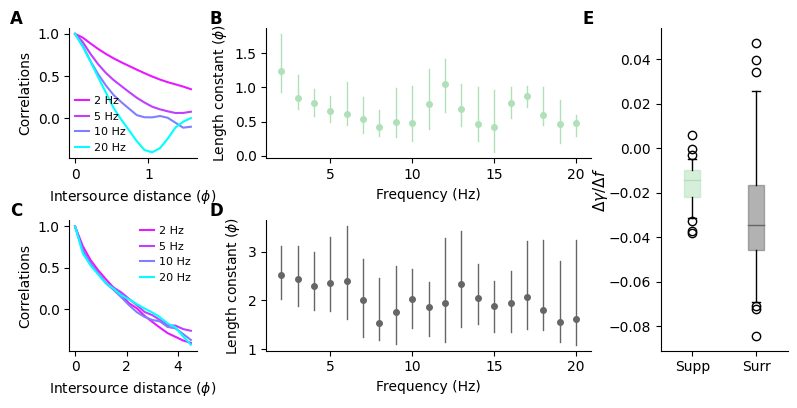

In [26]:
reload(fpf)
for ds in ["bw", "16Ts"]:
    which_ds = [ds,"s=p_0"]
    ax, ax_γ = fpf.plot_length_constants_vs_frequency(data, which_ds, iprb)
    fpft.label_axes(ax + [ax_γ], "ABCDE",
                    fontsize=12, fontweight="bold",
                    dx = -0.01, dy=0.01,
                    align_x = [[0,2],[1,3]],
                    align_y = [[0,1,4]])
    
    file_name = f"{fig_dir_full}/length_vs_freq_{which_ds[0]}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    


# Regressing information on frequency

(10, 5.0)
ils_origin=<Quantity(0.849803825, 'boulder16_pitch')>
ils_probe=<Quantity(2.64784884, 'boulder16_pitch')>


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:1315: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_coef.set_yticklabels([f"{yti:g}" for yti in ax_coef.get_yticks()], fontsize=10)


Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/reg_coefs_bw.pdf.


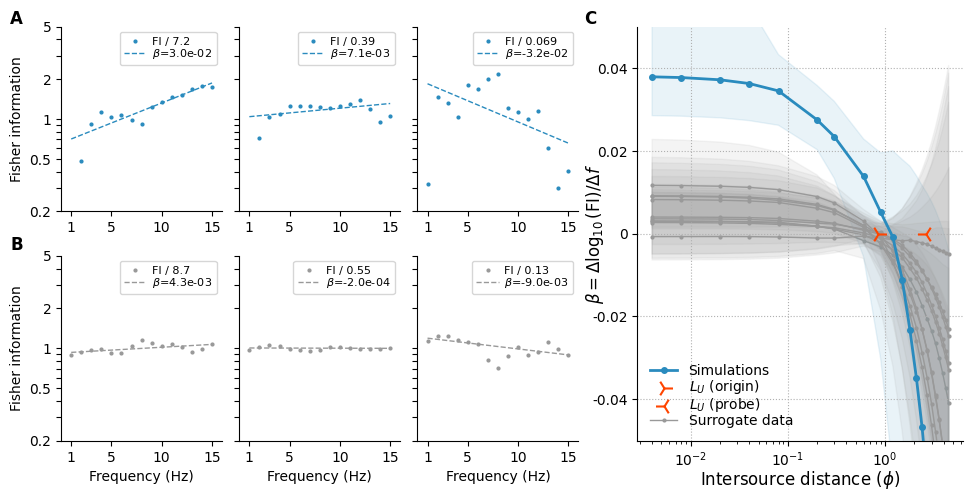

(10, 5.0)


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:1315: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_coef.set_yticklabels([f"{yti:g}" for yti in ax_coef.get_yticks()], fontsize=10)


Wrote figs/kaiser16/1s/fit_k=False/fit_b=True/reg_coefs_16Ts.pdf.


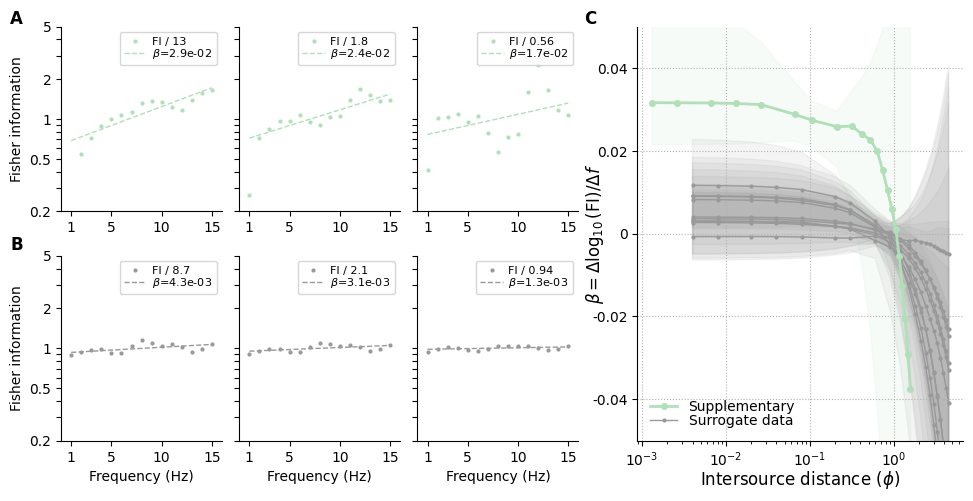

In [27]:
reload(fpf)
for ds in ["bw", "16Ts"]:
    #if ds != "bw": continue
    #which_ds = [ds,"s=p"]
    #ax, ax_coef = fpf.plot_information_regression(data, which_ds, iprb, plot_ils = True)    

    which_ds = [f"s=p_{i}" for i in range(10)]
    ind_detail = []
    # Order which_ds with the ones we want to highlight first, indicated in ind_detail, then the rest.
    which_ds = [which_ds[i] for i in ind_detail] + [which_ds[i] for i in range(len(which_ds)) if i not in ind_detail]
    names = {ki:ki for ki in which_ds}
    names["bw"] = "boulder"
    # cols = {k:cm.hsv(i/(len(which_ds))) for i,k in enumerate(which_ds)}
    ax, ax_coef = fpf.plot_information_regression(data, [ds] + which_ds, iprb, plot_ils = True, do_label = [True]*2 + [False]*(len(which_ds)-1))
    

    fpft.label_axes([ax[0][0], ax[1][0], ax_coef], "ABC",
                    fontsize=12, fontweight="bold",
                    align_x = [[0,1]],
                    align_y = [[0,2]])
    
    file_name = f"{fig_dir_full}/reg_coefs_{ds}.pdf"
    #tight_layout(pad=0,w_pad=0, h_pad=0)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()


# Compute the spectrum

In [28]:
Info = namedtuple('Info','name,color')
infos = {"16Ts": Info(name="Supp. dataset",               color = "dodgerblue"),
         "bw":   Info(name="Main dataset",                color = "orangered"),
         "s=p_0":  Info(name="Surrogate (all =)",     color = "pink"),
         "s=w":  Info(name="Surrogate (all =, white)",    color = "green"),
         "shw":  Info(name="Surrogate (high>low, white)", color = "silver"),
         "shp":  Info(name="Surrogate (high>low)",  color = "violet"),
         "s=w_q0":  Info(name="Surrogate (quad, ϕ=0, white)", color="blue"),
         "s=w_q1":  Info(name="Surrogate (quad, ϕ=π/3, white)", color="green"),
}

Wrote figs/boxcar/1s/spectra.pdf.


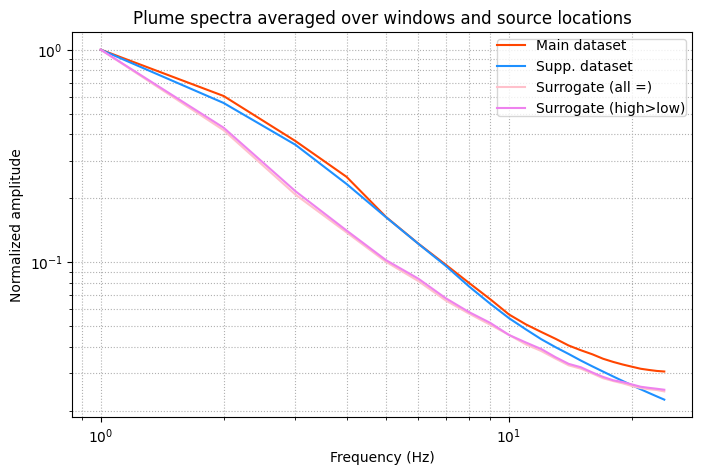

In [29]:
figure(figsize=(8,5))
for ki, k in enumerate(sorted(data, key=lambda x: infos[x].name if x in infos else x)):
    if k not in infos: continue
    f = []
    for _, s in data[k].stft.items():
        fr, tt, S = s[0]
        f.append(np.abs(S))
        
    fs = F.fs.to("Hz").magnitude
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1] * (10**0),
           label=infos[k].name,
           color=infos[k].color)
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
fig_dir = fpft.get_fig_dir(window_shape="boxcar", window_length=1*UNITS.s, create=True)
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Velocity autocorrelation functions

Wrote figs/ils_supp.pdf.


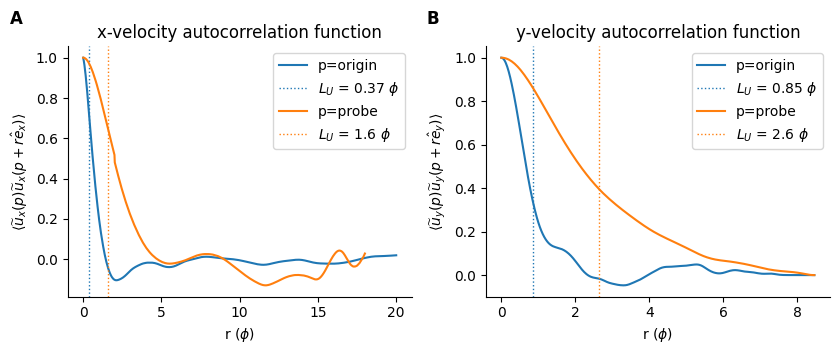

In [30]:
ils = data["bw"].sim0.integral_length_scales
keys = ils.keys()
figure(figsize=(8.5,3.5))
ax = []
for i, d in enumerate("xy"):
    ax.append(subplot(1,2,i+1))
    orig_key = (0 * UNITS.m, 0 * UNITS.m, d)
    probe_key = [k for k in keys if k[-1]==d and k!=orig_key][0]
    for j, (k, name) in enumerate(zip([orig_key,probe_key], ["origin", "probe"])):
        res   = ils[k]
        fr, l = res["fr"], res["l"]
        # l = nansum(fr) * ds
        ds = l / nansum(fr)
        xx = arange(len(fr))*ds.to(data["bw"].pitch).magnitude
        plot(xx, fr, label=f"p={name}")
        lmag = l.to(data["bw"].pitch).magnitude
        gca().axvline(lmag, color=f"C{j}", linewidth=1, linestyle=":", label = f"$L_U$ = {lmag:.2} {fpf.pitch_sym}")
    legend()
    ylabel(f"$\langle \\widetilde u_{d}(p) \\widetilde u_{d}(p + r \hat e_{d}) \\rangle$")
    xlabel(f"r ({fpf.pitch_sym})")
    title(f"{d}-velocity autocorrelation function")
    fpft.spines_off(gca())
tight_layout()
fpft.label_axes(ax, "AB",
                    fontsize=12, fontweight="bold",
                    align_y = [[0,1]])
file_name = f"figs/ils_supp.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    

# The End

# Sandbox

## Plot λ for random frequencies

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


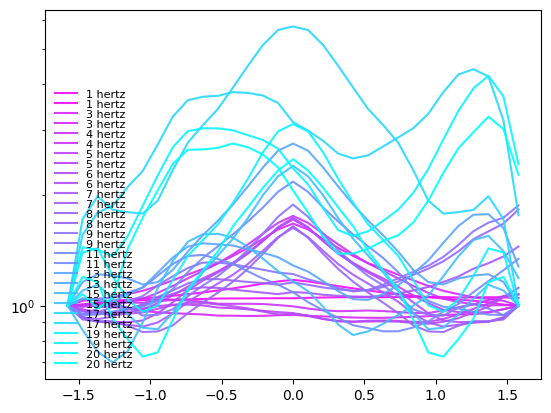

In [31]:
random.seed(1)
F = data["16Ts"]
d = np.array(list(F.la[0].keys()))/F.pitch.to(UNITS.um).magnitude
ibs = 0
la = np.array([F.la[0][ki][ibs] for ki in F.la[0]])
la1=la/la[0]
for i, f in zip(arange(la1.shape[1]), F.freqs):
    if f == 0 * UNITS.Hz: continue
    if f>20 * UNITS.Hz: break
    if rand()> 20/(len(F.freqs)*20/50): continue
    semilogy(d, la1[:, i], color = fpft.set_alpha(cm.cool_r(f/20 * UNITS.Hz),0.9), label = f"{f:g}");
#ylim(0.2,1)
legend(labelspacing=0, frameon=False, loc="lower left", fontsize=8)

# Manually run regressions

In [32]:
from sklearn.linear_model import LinearRegression, HuberRegressor
Regressor = LinearRegression()
Regressor = HuberRegressor(max_iter = 10000)

In [33]:
F         = data["bw"]
freq_min  = 1  * UNITS.Hz
freq_max  = 20 * UNITS.Hz
freqs     = F.freqs.to(UNITS.Hz).magnitude
n_bs, n_I_freq, n_d = F.I[0].shape  
ind       = (F.freqs >= freq_min) & (F.freqs <= freq_max)
reg_coefs = {}
lr        = Regressor
for j, Ibs in enumerate(F.I[0]):
    print(f"{j}", end=",")
    reg_coefs[j] = []
    for i in range(n_d):
        yy = Ibs[ind[:n_I_freq],i]
        xx = freqs[ind][:len(yy)]
        ivld = ~np.isnan(yy) & (yy>1e-15) & ~np.isinf(yy) 
        if len(ivld) - sum(ivld):
            pass
            print(f"Found {len(ivld) - sum(ivld)} out of range y values for ibs={j}, {i=}, d={F.I_dists[i]/F.pitch.to(UNITS.um).magnitude:.2f} ϕ")
        if len(ivld)>=5:
            lr.fit(xx[ivld].reshape(-1,1), np.log10(yy[ivld]))
            reg_coefs[j].append((xx,yy,ivld,[lr.intercept_] + list(lr.coef_)))
        else:
            reg_coefs[j].append((xx,yy,ivld,[np.nan]*2))          
            


0,1,

2,Found 1 out of range y values for ibs=2, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=2, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=2, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=2, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=2, i=10, d=1.50 ϕ
Found 3 out of range y values for ibs=2, i=11, d=1.80 ϕ
Found 3 out of range y values for ibs=2, i=12, d=2.10 ϕ
Found 3 out of range y values for ibs=2, i=13, d=2.40 ϕ
Found 4 out of range y values for ibs=2, i=14, d=2.70 ϕ
Found 4 out of range y values for ibs=2, i=15, d=3.00 ϕ
Found 5 out of range y values for ibs=2, i=16, d=3.30 ϕ
Found 5 out of range y values for ibs=2, i=17, d=3.60 ϕ
Found 5 out of range y values for ibs=2, i=18, d=3.90 ϕ
Found 5 out of range y values for ibs=2, i=19, d=4.20 ϕ
Found 5 out of range y values for ibs=2, i=20, d=4.50 ϕ
3,4,

5,Found 1 out of range y values for ibs=5, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=5, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=5, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=5, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=5, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=5, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=5, i=20, d=4.50 ϕ
6,Found 1 out of range y values for ibs=6, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=6, i=19, d=4.20 ϕ


Found 1 out of range y values for ibs=6, i=20, d=4.50 ϕ
7,8,9,

10,Found 1 out of range y values for ibs=10, i=20, d=4.50 ϕ
11,Found 1 out of range y values for ibs=11, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=11, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=11, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=11, i=20, d=4.50 ϕ
12,

13,Found 1 out of range y values for ibs=13, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=13, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=13, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=13, i=10, d=1.50 ϕ
Found 2 out of range y values for ibs=13, i=11, d=1.80 ϕ
Found 2 out of range y values for ibs=13, i=12, d=2.10 ϕ
Found 2 out of range y values for ibs=13, i=13, d=2.40 ϕ
Found 2 out of range y values for ibs=13, i=14, d=2.70 ϕ
Found 3 out of range y values for ibs=13, i=15, d=3.00 ϕ
Found 3 out of range y values for ibs=13, i=16, d=3.30 ϕ
Found 3 out of range y values for ibs=13, i=17, d=3.60 ϕ
Found 4 out of range y values for ibs=13, i=18, d=3.90 ϕ
Found 4 out of range y values for ibs=13, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=13, i=20, d=4.50 ϕ
14,Found 1 out of range y values for ibs=14, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=14, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=14, i=11, d=1.80 ϕ
Found 1 out of range y values

Found 1 out of range y values for ibs=15, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=15, i=7, d=0.60 ϕ
Found 2 out of range y values for ibs=15, i=8, d=0.90 ϕ
Found 3 out of range y values for ibs=15, i=9, d=1.20 ϕ
Found 3 out of range y values for ibs=15, i=10, d=1.50 ϕ
Found 4 out of range y values for ibs=15, i=11, d=1.80 ϕ
Found 6 out of range y values for ibs=15, i=12, d=2.10 ϕ
Found 6 out of range y values for ibs=15, i=13, d=2.40 ϕ
Found 6 out of range y values for ibs=15, i=14, d=2.70 ϕ
Found 6 out of range y values for ibs=15, i=15, d=3.00 ϕ
Found 6 out of range y values for ibs=15, i=16, d=3.30 ϕ
Found 7 out of range y values for ibs=15, i=17, d=3.60 ϕ
Found 7 out of range y values for ibs=15, i=18, d=3.90 ϕ
Found 8 out of range y values for ibs=15, i=19, d=4.20 ϕ
Found 8 out of range y values for ibs=15, i=20, d=4.50 ϕ
16,17,

Found 1 out of range y values for ibs=17, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=17, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=17, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=17, i=20, d=4.50 ϕ
18,19,

20,21,Found 1 out of range y values for ibs=21, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=21, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=21, i=20, d=4.50 ϕ
22,

Found 1 out of range y values for ibs=22, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=22, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=22, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=22, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=22, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=22, i=12, d=2.10 ϕ
Found 2 out of range y values for ibs=22, i=13, d=2.40 ϕ
Found 2 out of range y values for ibs=22, i=14, d=2.70 ϕ
Found 3 out of range y values for ibs=22, i=15, d=3.00 ϕ
Found 3 out of range y values for ibs=22, i=16, d=3.30 ϕ
Found 3 out of range y values for ibs=22, i=17, d=3.60 ϕ
Found 3 out of range y values for ibs=22, i=18, d=3.90 ϕ
Found 4 out of range y values for ibs=22, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=22, i=20, d=4.50 ϕ
23,Found 1 out of range y values for ibs=23, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=23, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=23, i=20, d=4.50 ϕ
24,

Found 1 out of range y values for ibs=24, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=24, i=20, d=4.50 ϕ
25,Found 1 out of range y values for ibs=25, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=25, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=25, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=25, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=25, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=25, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=25, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=25, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=25, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=25, i=20, d=4.50 ϕ
26,Found 1 out of range y values for ibs=26, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=26, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=26, i=16, d=3.30 ϕ
Found 2 out of range y values for ibs=26, i=17, d=3.60 ϕ


Found 4 out of range y values for ibs=26, i=18, d=3.90 ϕ
Found 4 out of range y values for ibs=26, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=26, i=20, d=4.50 ϕ
27,Found 1 out of range y values for ibs=27, i=3, d=0.04 ϕ
Found 1 out of range y values for ibs=27, i=4, d=0.08 ϕ
Found 1 out of range y values for ibs=27, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=27, i=6, d=0.30 ϕ
Found 3 out of range y values for ibs=27, i=7, d=0.60 ϕ
Found 5 out of range y values for ibs=27, i=8, d=0.90 ϕ
Found 7 out of range y values for ibs=27, i=9, d=1.20 ϕ
Found 7 out of range y values for ibs=27, i=10, d=1.50 ϕ
Found 7 out of range y values for ibs=27, i=11, d=1.80 ϕ
Found 7 out of range y values for ibs=27, i=12, d=2.10 ϕ
Found 7 out of range y values for ibs=27, i=13, d=2.40 ϕ
Found 8 out of range y values for ibs=27, i=14, d=2.70 ϕ
Found 8 out of range y values for ibs=27, i=15, d=3.00 ϕ
Found 9 out of range y values for ibs=27, i=16, d=3.30 ϕ
Found 10 out of range y values for 

29,Found 1 out of range y values for ibs=29, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=29, i=6, d=0.30 ϕ
Found 2 out of range y values for ibs=29, i=7, d=0.60 ϕ
Found 4 out of range y values for ibs=29, i=8, d=0.90 ϕ
Found 4 out of range y values for ibs=29, i=9, d=1.20 ϕ
Found 4 out of range y values for ibs=29, i=10, d=1.50 ϕ
Found 4 out of range y values for ibs=29, i=11, d=1.80 ϕ
Found 4 out of range y values for ibs=29, i=12, d=2.10 ϕ
Found 6 out of range y values for ibs=29, i=13, d=2.40 ϕ
Found 7 out of range y values for ibs=29, i=14, d=2.70 ϕ
Found 8 out of range y values for ibs=29, i=15, d=3.00 ϕ
Found 8 out of range y values for ibs=29, i=16, d=3.30 ϕ
Found 9 out of range y values for ibs=29, i=17, d=3.60 ϕ
Found 9 out of range y values for ibs=29, i=18, d=3.90 ϕ
Found 10 out of range y values for ibs=29, i=19, d=4.20 ϕ
Found 10 out of range y values for ibs=29, i=20, d=4.50 ϕ
30,31,

32,33,34,

Found 1 out of range y values for ibs=34, i=20, d=4.50 ϕ
35,Found 1 out of range y values for ibs=35, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=35, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=35, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=35, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=35, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=35, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=35, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=35, i=12, d=2.10 ϕ
Found 3 out of range y values for ibs=35, i=13, d=2.40 ϕ
Found 3 out of range y values for ibs=35, i=14, d=2.70 ϕ
Found 3 out of range y values for ibs=35, i=15, d=3.00 ϕ
Found 4 out of range y values for ibs=35, i=16, d=3.30 ϕ
Found 6 out of range y values for ibs=35, i=17, d=3.60 ϕ
Found 6 out of range y values for ibs=35, i=18, d=3.90 ϕ
Found 7 out of range y values for ibs=35, i=19, d=4.20 ϕ
Found 8 out of range y values for ibs=35, i=20, d=4.50 ϕ
36,Found 1 out of range y values 

Found 2 out of range y values for ibs=36, i=18, d=3.90 ϕ
Found 3 out of range y values for ibs=36, i=19, d=4.20 ϕ
Found 3 out of range y values for ibs=36, i=20, d=4.50 ϕ
37,Found 1 out of range y values for ibs=37, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=37, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=37, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=37, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=37, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=37, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=37, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=37, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=37, i=20, d=4.50 ϕ
38,Found 1 out of range y values for ibs=38, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=38, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=38, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=38, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=38, i=10, d=1.50 ϕ
Found 1 out of range y values

Found 5 out of range y values for ibs=38, i=19, d=4.20 ϕ
Found 5 out of range y values for ibs=38, i=20, d=4.50 ϕ
39,Found 1 out of range y values for ibs=39, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=39, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=39, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=39, i=8, d=0.90 ϕ
Found 2 out of range y values for ibs=39, i=9, d=1.20 ϕ
Found 2 out of range y values for ibs=39, i=10, d=1.50 ϕ
Found 3 out of range y values for ibs=39, i=11, d=1.80 ϕ
Found 4 out of range y values for ibs=39, i=12, d=2.10 ϕ
Found 4 out of range y values for ibs=39, i=13, d=2.40 ϕ
Found 5 out of range y values for ibs=39, i=14, d=2.70 ϕ
Found 6 out of range y values for ibs=39, i=15, d=3.00 ϕ
Found 6 out of range y values for ibs=39, i=16, d=3.30 ϕ
Found 7 out of range y values for ibs=39, i=17, d=3.60 ϕ
Found 8 out of range y values for ibs=39, i=18, d=3.90 ϕ
Found 8 out of range y values for ibs=39, i=19, d=4.20 ϕ
Found 8 out of range y values for

41,Found 1 out of range y values for ibs=41, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=41, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=41, i=20, d=4.50 ϕ
42,

43,44,45,

46,47,Found 1 out of range y values for ibs=47, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=47, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=47, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=47, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=47, i=18, d=3.90 ϕ
Found 2 out of range y values for ibs=47, i=19, d=4.20 ϕ
Found 3 out of range y values for ibs=47, i=20, d=4.50 ϕ
48,

49,50,Found 1 out of range y values for ibs=50, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=50, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=50, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=50, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=50, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=50, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=50, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=50, i=20, d=4.50 ϕ


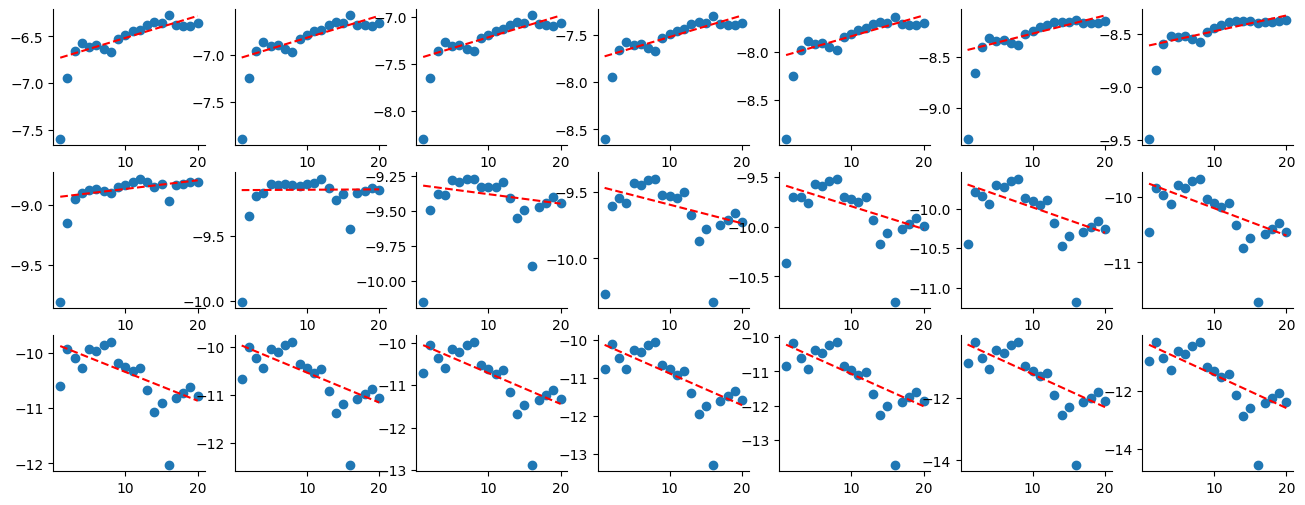

In [34]:
which_ibs = 0
figure(figsize=(16,6))
for i in range(n_d):
    xx, yy, ivld, coefs = reg_coefs[which_ibs][i]
    if not np.isnan(coefs[0]):
        lr.intercept_ = coefs[0]
        lr.coef_      = np.array(coefs[1:])
        logye         = lr.predict(np.array(xx[ivld]).reshape(-1,1))
    subplot(3,7,i+1)
    scatter(xx[ivld], log10(yy[ivld]))
    scatter(xx[~ivld], log10(yy[~ivld]), c="r")
    plot(xx[ivld], logye,"r--")
    fpft.spines_off(gca())
    #gca().set_xticks([])
    #gca().set_yticks([])
    
    